<h1>
    <center>
        TMA4320 Prosjekt 2

## Innholdsfortegnelse

### 1. Introduksjon
### 2. Algoritme og hjelpefunksjoner
### 3. Første testproblem: Punkter i planet
### 4. Andre testproblem: MNIST - siffergjenkjenning
### 5. Avslutning


## 1. Introduksjon

Formålet med prosjektet er å gi en introduksjon til maskinlæring, nærmere bestemt dyplæring og dype nevrale nettverk, ved egen implementering av algoritmene. 
Ideen er å trene dataprogrammet til å gjenkjenne bildeelementer i to ulike testproblemer. I det første testproblemet er problemstillingen forenklet til gjenkjenning av fargede datapunkt, mens i det andre testproblemet skal programmet kunne skille mellom to ulike håndskrevne sifre. 
Denne rapporten skal først presentere den grunneleggende algoritmen og dens hjelpefunksjoner som benyttes i treningsfasen og hovedsaklig er lik for begge problemstillingene, før hver problemstilling blir framstilt i detalj.
Valg av startparametre skal begrunnes og parametrene som ble funnet i treningsfasen skal presenteres. Deretter skal modellen med disse fikserte parametrene kjøres med nye data og resultatene bli lagt fram og diskutert.

## 2. Algoritme og hjelpefunksjoner

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
import random 

In [26]:
from loader import load_mnist
from loader import get_dataset
from spirals import get_data_spiral_2d
from plotting import plot_progression, plot_model, plot_separation
from files import write_spiral_to_file, read_spiral_from_file, writeParams, readParams


Importerte funksjoner fra filer som er brukt i prosjektet. Disse er brukt for å generere data for det første testproblemet, lese inn data for bildene i MNIST for det andre testproblemet og for å plotte resultatet.

Algoritmen er blitt delt inn i flere mindre funksjoner for å forenkle kodestrukturen og gjøre den mer oversiktlig. 
Hovedsaklig er den delt inn i å transformere input-data mellom lagene, å bestemme gradienten til $J = \frac{1}{2}||\bf{Z-c}||$ med hensyn på vekter, bias, $\omega$ og $\mu$ og optimering av nettverket med hensyn på disse. I tillegg til dette kommer flere hjelpefunksjoner som benyttes av de overordnede funksjonene.

In [3]:
def getRandomParam(d=2, K=20):
    w_k=np.random.randn(K,d,d)
    b_k=np.random.randn(K,d)
    omega = np.random.randn(d)
    my = np.random.rand(1)
    return w_k,b_k,omega, my

Som sett ovenfor genererer getRandomParam tilfeldige startverdier for vekter, bias, $\omega$ og $\mu$ ved å trekke fra en standardnormalfordeling.

In [4]:
def sigma(x):
    return(np.tanh(x))

def sigma_diff(x):
    return(1-np.tanh(x)**2)

def eta(x):
    x[x > 350] = 350
    return(np.exp(x)/(np.exp(x)+1))

def eta_diff(x):
    x[x > 350] = 350
    return np.exp(x)/(np.exp(x) + 1)**2

Aktiveringsfunksjonen $\sigma$ ovenfor benyttes i transformasjonen av $\bf{Y_k}$ mellom lagene, mens $\eta$ brukes i projiseringen fra siste lag på en skalar z. 
Både $\sigma'$ og $\eta'$ benyytes i utledningen av gradienten.

Ved bruk av $\exp(x)$ i $\eta$ og $\eta'$, vil datamaskinen gi overflow error for store x. Om man sender inn svært store $x$, er forskjellen på om $x = 350$ og $x = 700$ marginal, fordi funksjonene returnerer henholdsvis essensielt 1 og 0. Bruken av en maksverdi vil derfor fjerne overflow error, og minimalt endre returverdien. 

In [5]:
  def findNextYVec(Y_k, W_k, b_k, h):
    vec_for_sigma = np.dot(W_k, Y_k) + b_k
    sigma_vec = sigma(vec_for_sigma)
    return(Y_k+h*sigma_vec)

def findNextYMat(Y_k_mat, W_k, b_k, h):
    numberOfColumns = Y_k_mat.shape[1]
    nextYMat = np.zeros((Y_k_mat.shape[0], numberOfColumns))
    for column in range(numberOfColumns):
        Y_k = Y_k_mat[:, column]
        nextYMat[:, column] = findNextYVec(Y_k, W_k, b_k, h)
    return(np.array(nextYMat))

Disse funksjonene brukes for å hente ut de transformerte bildene, dvs. anvende vektene og biasene. findNextYVec() finner for hvert enkelt bilde, mens findNextYMat() kaller findNextYVec() for å finne den transformerte bildesamlingen.

In [16]:
def findZvalue(Y_k_mat, w_vec, my):
    vec_for_eta = np.dot(w_vec, Y_k_mat) + my
    return(eta(vec_for_eta))

def J(Z,c):
    return 0.5*np.linalg.norm(Z-c)**2

In [7]:
def makeMatrixFromVec(a, b):
    return_matrix = np.zeros((len(a), len(b)))
    for i in range(len(b)):
        return_matrix[:, i] = b[i]*a
    return(return_matrix)

def findGradJ(Z_vec, W_K, Y_K, Y_end, w_vec, c_vec, my, b_K, h, K):
    #Regner ut et produkt som går igjen for å spare noen utregninger
    prod_to_re_use = eta_diff(np.dot(w_vec, Y_end)+my)
    
    J_diff_my = np.dot(prod_to_re_use, Z_vec-c_vec)
    
    #Mellomregning:
    diff_my_vec_for_product = np.multiply(Z_vec - c_vec, prod_to_re_use)
    J_diff_w = np.dot(Y_end, diff_my_vec_for_product)
    
    P_K = makeMatrixFromVec(w_vec, np.multiply(Z_vec - c_vec, prod_to_re_use))

    P_k_liste = [P_K]
    for i in range(K-1, -1, -1):
        WdotY = np.dot(W_K[i], Y_K[i])
        b_i_mat = np.array([np.array([b_K[i][j] for e in range(WdotY.shape[1])]) for j in range(WdotY.shape[0])])
        matrix_for_sigma_diff =  WdotY + b_i_mat
        matrix_for_product = np.multiply(sigma_diff(matrix_for_sigma_diff), P_k_liste[0])
        P_i = P_k_liste[0] + h * np.dot(np.transpose(W_K[i]), matrix_for_product)
        P_k_liste.insert(0, P_i)
    
    J_diff_W_matrix = []
    J_diff_b_vec = []
    for j in range(K):
        W_jY_j = np.dot(W_K[j], Y_K[j])
        b_j_mat = np.array([np.array([b_K[j][c] for e in range(W_jY_j.shape[1])]) for c in range(W_jY_j.shape[0])])
        one_vector = np.full((W_jY_j.shape[1]), 1)
        J_diff_W_matrix.append(h*np.dot(P_k_liste[j+1]*sigma_diff(W_jY_j + b_j_mat), np.transpose(Y_K[j])))
        J_diff_b_vec.append(h*np.dot(P_k_liste[j+1]*eta_diff(W_jY_j + b_j_mat), one_vector))
        
    
    return(J_diff_W_matrix, J_diff_b_vec, J_diff_w, J_diff_my)

Vi har valgt å representere vektorene våre som rene numpy array, altså uten å sette hvert element inni sin egen array.
Da vil ikke vanlig @ eller np.dot gi ut en matrise, men en skalar. makeMatrixFromVec() håndterer prikkproduktet.

In [8]:
def newU(W_k,b_vec,w,my,tau,J_diff_W_matrix, J_diff_b_vec, J_diff_w, J_diff_my):
    W_k = W_k - np.multiply(J_diff_W_matrix,tau)
    b_vec = b_vec - np.multiply(J_diff_b_vec, tau)
    w = w - tau*J_diff_w
    my = my -tau*J_diff_my
    return W_k, b_vec,w,my

def adam2(m,v,g,j):
    beta1 = 0.9
    beta2 = 0.999
    alpha = 0.01
    epsilon = 1.0E-8

    m = np.multiply(beta1,m) + np.multiply((1-beta1),g)
    v = np.multiply(beta2,v) + np.multiply((1-beta2),np.multiply(g,g))
    m_hat = np.multiply(m,1/(1-beta1**j))
    v_hat = np.multiply(v,1/(1-beta2**j))
    
    J = np.multiply(alpha,np.multiply(m_hat,1/((np.sqrt(v_hat)+epsilon))))
    
    return m,v,J

def getStartMandV(w,b,o,m):
    mW = np.zeros_like(w)
    mb = np.zeros_like(b)
    mOmega = np.zeros_like(o)
    mMy = np.zeros_like(m)

    return mW,mb,mOmega,mMy

Funksjonene ovenfor benyttes for å optimere vekter, bias, $\omega$ og $\mu$.
newU tilsvarer en plain vanilla gradient descent, der vi følger gradienten i avtagende retning og der læringsparameteren $\tau$ bestemmer hvor langt vi følger gradienten.

Funksjonen adam2 tilsvarer ADAM descent metoden, som tilpasser læringsraten til parameteren, dvs. vi beveger oss ulik lengde langsmed gradienten med hensyn på ulike parametre.
getStartMandV er en hjelpefunksjon som genererer startparametrene m og v, som fungerer som et slags gjennomsnitt og kvadrert gjennomsnitt av tidligere iterasjoners gradienter, for adamfunksjonen. Før første iterasjon ønsker vi å sette m=v=0 for alle parametre.

In [10]:
def success(z, int_labels):
    z = np.asanyarray(np.around(z, 0), dtype = int)
    sum = 0
    for i in range(len(z)):
        if z[i] == int_labels[i]:
            sum += 1
    return(sum/len(z))

Funksjonen success() sammenlikner $Z$ med label for hvert bilde og returnerer prosentandelen som stemmer overens. 

In [21]:
def forward_function(Y_0, W_k, b_k, h):
    Y_k = [Y_0]
    for i in range(W_k.shape[0]):
        Y_next = findNextYMat(Y_k[-1], W_k[i], b_k[i], h)
        Y_k.append(Y_next)
    return(np.array(Y_k))


def last_function(Y_K_final, omega, my): 
    Z=findZvalue(Y_K_final, omega, my)
    return Z  

forward_function() og last_function() er hjelpefunksjoner for å plotte det første testproblemet. forward_function() tar den første matrisen $Y_{0}$ og finner den neste matrisen $Y_{k+1}$ ved hjelp av de lærte parameterne. Dette gjør den for alle lag $K$. last_function() tar derimot inn kun den siste matrisen $Y_{K}$ og returnerer $Z$ for denne. 

In [13]:
def plotJ(J_liste):
    x_akse = np.arange(len(J_liste))
    plt.scatter(x_akse, J_liste)
    plt.xlabel("Iterasjoner")
    plt.ylabel("J")
    plt.figure(10)
    plt.show()

## 3. Første testproblem: Punkter i planet

In [14]:
def trening(images, labels, AdamOrPlain = 'plain', n=1000, h = 0.05, K = 20):
    d = 2
    W_k, b_k, omega, my = getRandomParam(d, K)
    W_k = np.dot(W_k, 1/(d**2))
    omega = np.dot(omega, 1/(d**2))

    if AdamOrPlain == 'adam':
        mW, mb, mOmega, mMy = getStartMandV(W_k,b_k,omega,my)
        vW, vb, vOmega, vMy = getStartMandV(W_k, b_k, omega, my)

    elif AdamOrPlain == 'plain':
        tau = 0.1
    else:
        print("Må være enten adam eller plain")

    J_list = []

    for i in range(n):
        Y_k = [images]
        for i in range(W_k.shape[0]):
            Y_next = findNextYMat(Y_k[-1], W_k[i], b_k[i], h)
            Y_k.append(Y_next)

        z = findZvalue(Y_k[-1], omega, my)
        dJdW, dJdb, dJdOmega, dJdMy = findGradJ(z, W_k, Y_k[:-1], Y_k[-1], omega, labels, my, b_k, h, K)

        if AdamOrPlain == 'adam':
            mW, vW, JW = adam2(mW, vW, dJdW, i + 1)
            mb, vb, Jb = adam2(mb, vb, dJdb, i + 1)
            mOmega, vOmega, JOmega = adam2(mOmega, vOmega, dJdOmega, i + 1)
            mMy, vMy, JMy = adam2(mMy, vMy, dJdMy, i + 1)

            W_k -= JW
            b_k -= Jb
            omega -= JOmega
            my -= JMy

        elif AdamOrPlain == 'plain':
            W_k, b_k, omega, my = newU(W_k, b_k, omega, my, tau, dJdW, dJdb, dJdOmega, dJdMy)

        J_list.append(J(z, labels))

    return W_k, b_k, omega, my, z, J_list

### 3.1 PIP: Plain vanilla gradient descent

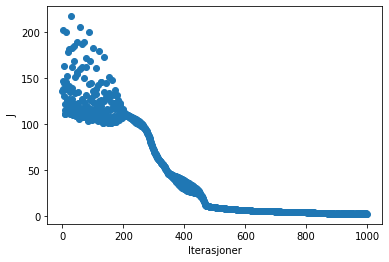

<Figure size 432x288 with 0 Axes>

Suksessrate: 0.997


In [17]:
images, labels = read_spiral_from_file()
W_pip_plain, b_pip_plain, omega_pip_plain, my_pip_plain, z_pip_plain, J_pip_plain = trening(images, labels, h = 0.05, n = 1000, AdamOrPlain = 'plain')
success_pip_plain = success(z_pip_plain,labels*1)

plotJ(J_pip_plain)
print("Suksessrate for treningsspiral:",success_pip_plain)

Suksessrate med testspiral: 0.995


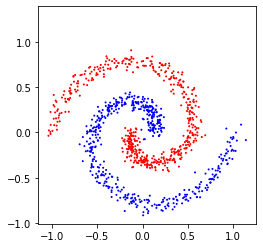

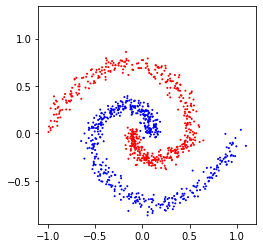

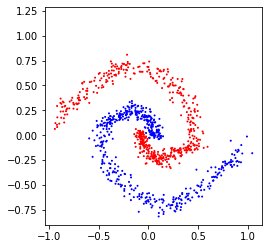

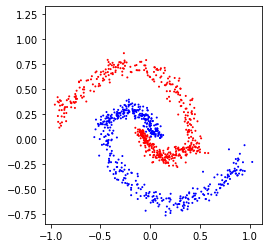

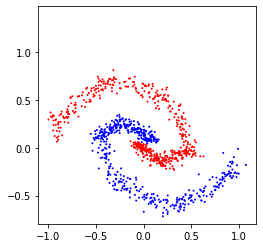

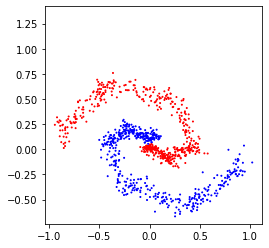

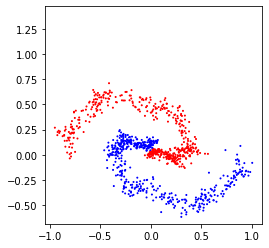

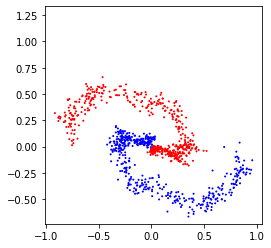

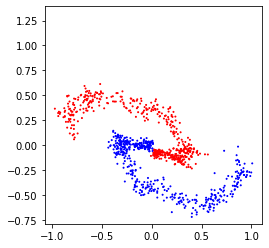

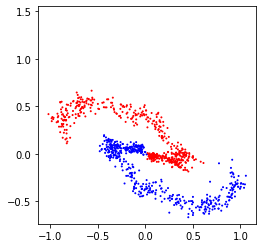

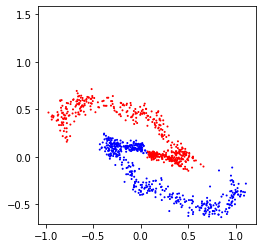

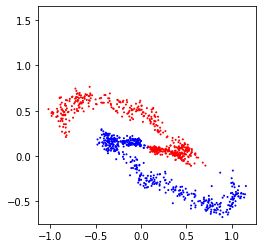

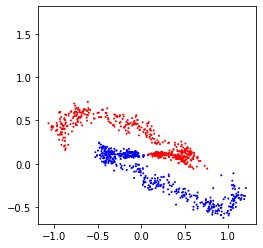

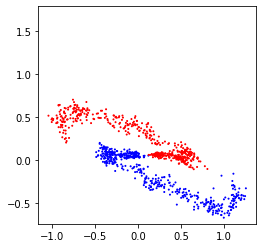

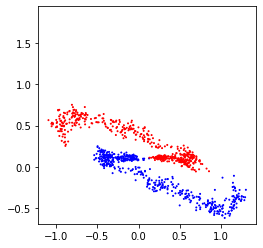

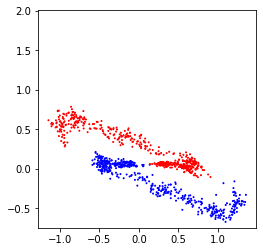

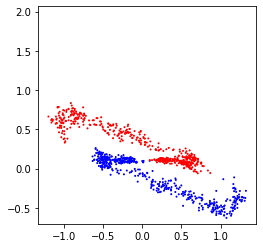

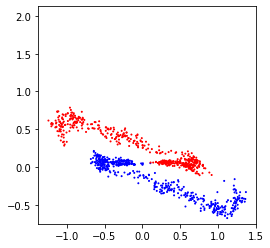

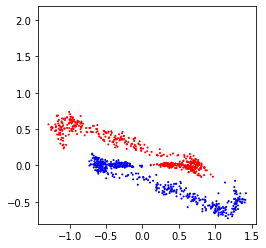

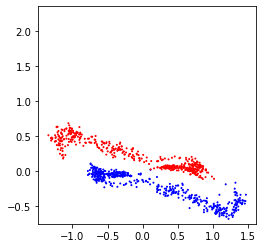

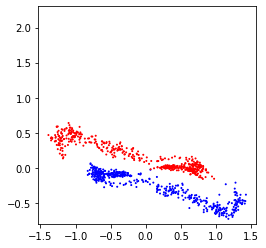

TypeError: plot_separation() takes 4 positional arguments but 6 were given

In [27]:
images_test, labels_test = read_spiral_from_file(filename = 'spiral_text_file2.txt')
Y_test_plain = forward_function(images_test, W_pip_plain, b_pip_plain, h = 0.05)
z_test_plain = findZvalue(Y_test_plain[-1], omega_pip_plain, my_pip_plain)
success_test_plain = success(z_test_plain, labels_test*1)
print("Suksessrate med testspiral:", success_test_plain)

plot_progression(Y_test_plain, labels_test*1)
plot_separation(last_function, Y_test_plain[-1], omega_pip_plain, my_pip_plain, labels_test*1, 200)
plot_model(forward_function, Y_test_plain[0], W_pip_plain, b_pip_plain, h = 0.05, )

### 3.2 PIP: ADAM descent

In [ ]:
W_pip_adam, b_pip_adam, omega_pip_adam, my_pip_adam, z_pip_adam, J_pip_adam = trening(images, labels, h = 0.1, n = 2000, AdamOrPlain = 'adam')
success_pip_adam = success(z_pip_adam,labels*1)

plotJ(J_pip_adam)
print("Suksessrate:",success_pip_adam)

In [ ]:
W_learned1, b_learned1, omega_learned1, my_learned1 = readParams(K = 20, d = 2, filename = 'spiral_adam_2000_it_0.1')
print("Wohoo")
#Y_k1 = forward_function(images, W_learned1, b_learned1, h)
#plot_progression(np.array(Y_k1), labels*1)
#plot_separation(findZvalue, Y_k1[-1], omega_learned1, my_learned1, labels*1, 2000)
#plot_model(forward_function, Y_k1[0], W_learned1, b_learned1, 0.1, labels*1, 100)
#print(success1)
#writeParams(W_learned1, b_learned1, omega_learned1, my_learned1, filename = 'spiral_adam_2000_it_0.1')

# 4. Andre testproblem: Siffergjenkjenning

In [ ]:
def trening_mnist(images, labels, AdamOrPlain = 'plain', n=1000, h = 0.05, K = 20):
    d = 28**2
    W_k, b_k, omega, my = getRandomParam(d, K)
    W_k = np.dot(W_k, 1/(d**2))
    omega = np.dot(omega, 1/(d**2))

    if AdamOrPlain == 'adam':
        mW, mb, mOmega, mMy = getStartMandV(W_k,b_k,omega,my)
        vW, vb, vOmega, vMy = getStartMandV(W_k, b_k, omega, my)

    elif AdamOrPlain == 'plain':
        tau = 0.1
    else:
        print("Må være enten adam eller plain")

    J_list = []

    for i in range(n):
        chunk_start = random.randint(0, images.shape[1] - 1000)
        Y_k = [images[:, chunk_start:chunk_start + 1000]]
        J_list.append(J(findZvalue(Y_k[-1], omega, my), labels[chunk_start:chunk_start + 1000]))
        for i in range(W_k.shape[0]):
            Y_next = findNextYMat(Y_k[-1], W_k[i], b_k[i], h)
            Y_k.append(Y_next)
        print("Ferdig med matrisene.")

        z = findZvalue(Y_k[-1], omega, my)
        dJdW, dJdb, dJdOmega, dJdMy = findGradJ(z, W_k, Y_k[:-1], Y_k[-1], omega, labels[chunk_start:chunk_start + 1000], my, b_k, h, K)

        if AdamOrPlain == 'adam':
            mW, vW, JW = adam2(mW, vW, dJdW, i + 1)
            mb, vb, Jb = adam2(mb, vb, dJdb, i + 1)
            mOmega, vOmega, JOmega = adam2(mOmega, vOmega, dJdOmega, i + 1)
            mMy, vMy, JMy = adam2(mMy, vMy, dJdMy, i + 1)

            W_k -= JW
            b_k -= Jb
            omega -= JOmega
            my -= JMy

        elif AdamOrPlain == 'plain':
            W_k, b_k, omega, my = newU(W_k, b_k, omega, my, tau, dJdW, dJdb, dJdOmega, dJdMy)

    J_list.append(J(z, labels[chunk_start:chunk_start + 1000]))

    return W_k, b_k, omega, my, z, J_list

In [ ]:
images_mnist, labels_raw_mnist = get_dataset(dataset = 'training')
labels_mnist = np.array([label[0]*1 for label in labels_raw_mnist])

W_mnist, b_mnist, omega_mnist, my_mnist, z_mnist, J_list_mnist = trening_mnist(images_mnist, labels_mnist, AdamOrPlain = 'adam', n = 20, h = 0.05, K = 3)
plotJ(J_list_mnist)

Tester MNIST ved å importere testbildene

In [ ]:
test_images, test_labels_raw = get_dataset(dataset = 'testing', digit1 = 2, digit2 = 7)
test_labels = np.array([label[0] for label in test_labels_raw])

#Tester først med alle treningsbildene
Y_mnist = forward_function(images_mnist, W_mnist, b_mnist, h = 0.05)
z_mnist = findZvalue(Y_mnist[-1], omega_minst, my_mnist)
success_mnist = success(z_mnist, labels_mnist)
print(success_mnist)

#Tester så med testbildene:
Y_mnist_test = forward_function(test_images, W_mnist, b_mnist, h = 0.05)
z_mnist_test = findZvalue(Y_mnist_test[-1], omega_mnist, my_mnist)
success_mnist_test = success(z_mnist_test, test_labels)
print(success_mnist_test)